In [2]:
import os
import h5py
import librosa
import itertools
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Name: /physical_device:GPU:0   Type: GPU


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10187985897528524165
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16072310784
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12073122974267287314
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [5]:
tf.test.is_gpu_available()

True

In [6]:
# For reproducibility purposes
np.random.seed(42)

In [7]:
"""
@description: Method to split a song into multiple songs using overlapping windows
"""
def splitsongs(X, y, window = 0.05, overlap = 0.2):
    # Empty lists to hold our results
    temp_X = []
    temp_y = []

    # Get the input song array size
    xshape = X.shape[0]
    chunk = int(xshape*window)
    offset = int(chunk*(1.-overlap))
    
    # Split the song and create new ones on windows
    spsong = [X[i:i+chunk] for i in range(0, xshape - chunk + offset, offset)]
    for s in spsong:
        if s.shape[0] != chunk:
            continue

        temp_X.append(s)
        temp_y.append(y)

    return np.array(temp_X), np.array(temp_y)

In [8]:
"""
@description: Method to convert a list of songs to a np array of melspectrograms
"""
def to_melspectrogram(songs, n_fft=1024, hop_length=256):
    # Transformation function
    melspec = lambda x: librosa.feature.melspectrogram(y = x, n_fft=n_fft,
        hop_length=hop_length, n_mels=128)[:,:,np.newaxis]

    # map transformation of input songs to melspectrogram using log-scale
    tsongs = map(melspec, songs)
    # np.array([librosa.power_to_db(s, ref=np.max) for s in list(tsongs)])
    return np.array(list(tsongs))

In [9]:
def split_convert(X, y):
    arr_specs, arr_genres = [], []
    
    # Convert to spectrograms and split into small windows
    for fn, genre in zip(X, y):
        signal, sr = librosa.load(fn)
        signal = signal[:song_samples]

        # Convert to dataset of spectograms/melspectograms
        signals, y = splitsongs(signal, genre)

    
        # Save files
        arr_genres.extend(y)
        arr_specs.extend(signals)
    
    return np.array(arr_specs), to_categorical(arr_genres)

In [10]:
def read_data(src_dir, genres, song_samples):    
    # Empty array of dicts with the processed features from all files
    arr_fn = []
    arr_genres = []

    # Get file list from the folders
    for x,_ in genres.items():
        folder = src_dir + x
        for root, subdirs, files in os.walk(folder):
            for file in files:
                file_name = folder + "/" + file

                # Save the file name and the genre
                arr_fn.append(file_name)
                arr_genres.append(genres[x])
    
    # Split into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        arr_fn, arr_genres, test_size=0.3, random_state=42, stratify=arr_genres
    )
    
    # Split into small segments and convert to spectrogram
    X_train, y_train = split_convert(X_train, y_train)
    X_test, y_test = split_convert(X_test, y_test)

    return X_train, X_test, y_train, y_test

In [11]:
# Parameters
gtzan_dir = '/kaggle/input/gtzan-custom/data/genres_original/'
song_samples = 660000
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}

# Read the data
X_train, X_test, y_train, y_test = read_data(gtzan_dir, genres, song_samples)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [12]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16776, 33000, 1) (7200, 33000, 1) (16776, 10) (7200, 10)


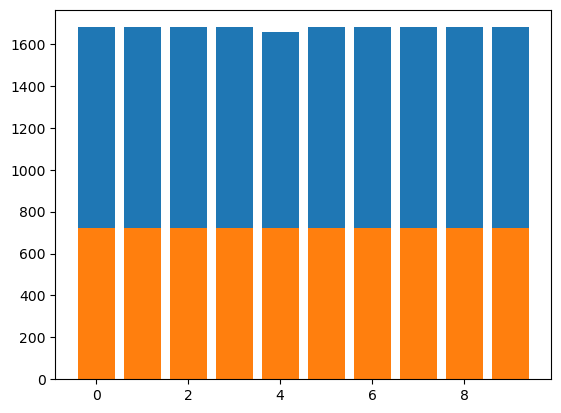

In [13]:
# Histogram for train and test 
values, count = np.unique(np.argmax(y_train, axis=1), return_counts=True)
plt.bar(values, count)

values, count = np.unique(np.argmax(y_test, axis=1), return_counts=True)
plt.bar(values, count)
plt.show()

In [14]:
from tensorflow.keras.utils import Sequence
def manipulate_noise(data, noise_factor):
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def manipulate_pitch(data, sampling_rate = 22050, pitch_factor = 4):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

def manipulate_time(data, shift_max, shift_direction, sampling_rate = 22050):
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right': shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0: augmented_data[:shift] = 0
    else: augmented_data[shift:] = 0
    return augmented_data

def augment(signal, noise = 0.5, pitch = 0.5, time = 0.5):
    threshold_to_modify = 0.5
    original_signal = np.copy(signal)
    modified = False
    if(np.random.rand() < threshold_to_modify):
        if np.random.rand() < noise: 
            modified = True
            signal = manipulate_noise(signal, 0.01)
        if np.random.rand() < pitch:
            modified = True
            signal = manipulate_pitch(signal)
        if np.random.rand() < time: 
            modified = True
            signal = manipulate_time(signal, 0.4, 'both')
    if(modified): return [original_signal, signal]
    else: return [original_signal]
        
        
class GTZANGenerator(Sequence):
    def __init__(self, X, y, batch_size, is_test):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.is_test = is_test
    
    def __len__(self):
        return int(np.ceil(len(self.X)/self.batch_size))
    
    def __getitem__(self, index):
        # Get batch indexes
        signals = self.X[index*self.batch_size:(index+1)*self.batch_size]
        return signals, self.y[index*self.batch_size:(index+1)*self.batch_size]
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        np.random.shuffle(self.indexes)
        return None

In [15]:
X_train_augmented = []
y_train_augmented = []
for index in tqdm(range(X_train.shape[0])):
    return_from_augment = augment(X_train[index][:, 0])
    X_train_augmented += return_from_augment
    y_train_augmented += [y_train[index] for k in range(len(return_from_augment))]
X_train_augmented = np.array(X_train_augmented).reshape((len(X_train_augmented), X_train[0].shape[0], 1))
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape)

100%|██████████| 16776/16776 [01:44<00:00, 160.31it/s]


(24122, 33000, 1)


In [16]:
X_train_augmented.shape, y_train_augmented.shape

((24122, 33000, 1), (24122, 10))

8006


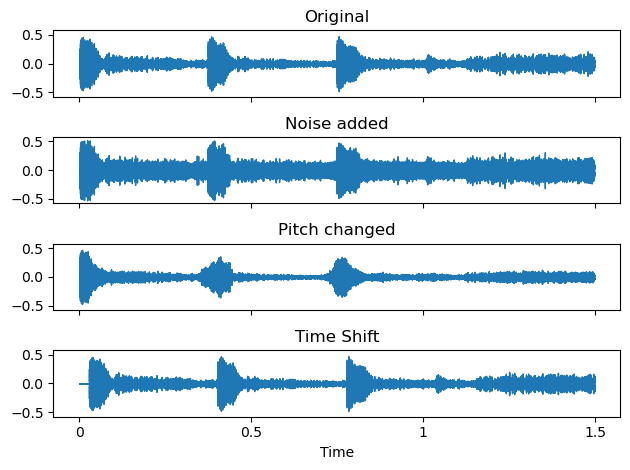

In [17]:
import matplotlib.pyplot as plt
import librosa.display
import random

random_index = random.choice(range(X_train.shape[0]))
print(random_index)
fig, ax = plt.subplots(nrows=4, sharex=True, sharey=True)
librosa.display.waveshow(X_train[random_index][:,0], sr=22050, ax=ax[0])
ax[0].set(title='Original')
ax[0].label_outer()

librosa.display.waveshow(manipulate_noise(X_train[random_index][:,0], 0.05), sr = 22050, ax = ax[1])
ax[1].set(title = 'Noise added')
ax[1].label_outer()

librosa.display.waveshow(manipulate_pitch(X_train[random_index][:,0]), sr = 22050, ax = ax[2])
ax[2].set(title = 'Pitch changed')
ax[2].label_outer()

librosa.display.waveshow(manipulate_time(X_train[random_index][:,0], 0.4, 'both'), sr = 22050, ax = ax[3])
ax[3].set(title = 'Time Shift')
ax[3].label_outer()
plt.tight_layout()

In [18]:
# Model Definition
import keras
def create_model(input_shape, num_genres):

    
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(128, kernel_size=3, strides=3, activation='relu', input_shape=input_shape))
    model.add(keras.layers.Conv1D(128, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=3))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv1D(512, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=3))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv1D(512, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=3))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv1D(256, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=3))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv1D(256, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=3))
    model.add(keras.layers.Dropout(0.25))

    model.add(keras.layers.Conv1D(256, kernel_size=3, strides=1, activation='relu'))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Dropout(0.25))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.25))
    model.add(keras.layers.Dense(10, activation='softmax'))

    # Print the model summary
    model.summary()

    return model

In [19]:
model = create_model(X_train_augmented[0].shape, len(genres))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 11000, 128)        512       
                                                                 
 conv1d_1 (Conv1D)           (None, 10998, 128)        49280     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3666, 128)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 3666, 128)         0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3664, 512)         197120    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1221, 512)        0         
 1D)                                                    

In [20]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate = 1e-4),
              metrics=['accuracy'])

In [21]:
reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.95,
    patience=3,
    verbose=1,
    mode='min',
    min_delta=0.0001,
    cooldown=2,
    min_lr=1e-6
)

In [22]:
# Generators
batch_size = 64
train_generator = GTZANGenerator(X_train_augmented, y_train_augmented, batch_size, False)
steps_per_epoch = np.ceil(len(X_train_augmented)/batch_size)
validation_generator = GTZANGenerator(X_test, y_test, batch_size, True)
val_steps = np.ceil(len(X_test)/batch_size)

In [23]:
hist = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=val_steps,
    epochs=25,
    verbose=1,
    callbacks=[reduceLROnPlat])

Epoch 1/25
377/377 [==============================] - 100s 237ms/step - loss: 2.2596 - accuracy: 0.1412 - val_loss: 2.2206 - val_accuracy: 0.1994 - lr: 1.0000e-04
Epoch 2/25
377/377 [==============================] - 85s 225ms/step - loss: 2.1725 - accuracy: 0.1901 - val_loss: 2.0931 - val_accuracy: 0.2099 - lr: 1.0000e-04
Epoch 3/25
377/377 [==============================] - 85s 226ms/step - loss: 2.0620 - accuracy: 0.2159 - val_loss: 2.0038 - val_accuracy: 0.2258 - lr: 1.0000e-04
Epoch 4/25
377/377 [==============================] - 85s 226ms/step - loss: 1.9802 - accuracy: 0.2589 - val_loss: 1.9580 - val_accuracy: 0.3331 - lr: 1.0000e-04
Epoch 5/25
377/377 [==============================] - 85s 226ms/step - loss: 1.9072 - accuracy: 0.2986 - val_loss: 1.9297 - val_accuracy: 0.3243 - lr: 1.0000e-04
Epoch 6/25
377/377 [==============================] - 85s 226ms/step - loss: 1.8623 - accuracy: 0.3185 - val_loss: 1.8284 - val_accuracy: 0.3589 - lr: 1.0000e-04
Epoch 7/25
377/377 [=======

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print("val_loss = {:.3f} and val_acc = {:.3f}".format(score[0], score[1]))

val_loss = 1.319 and val_acc = 0.556


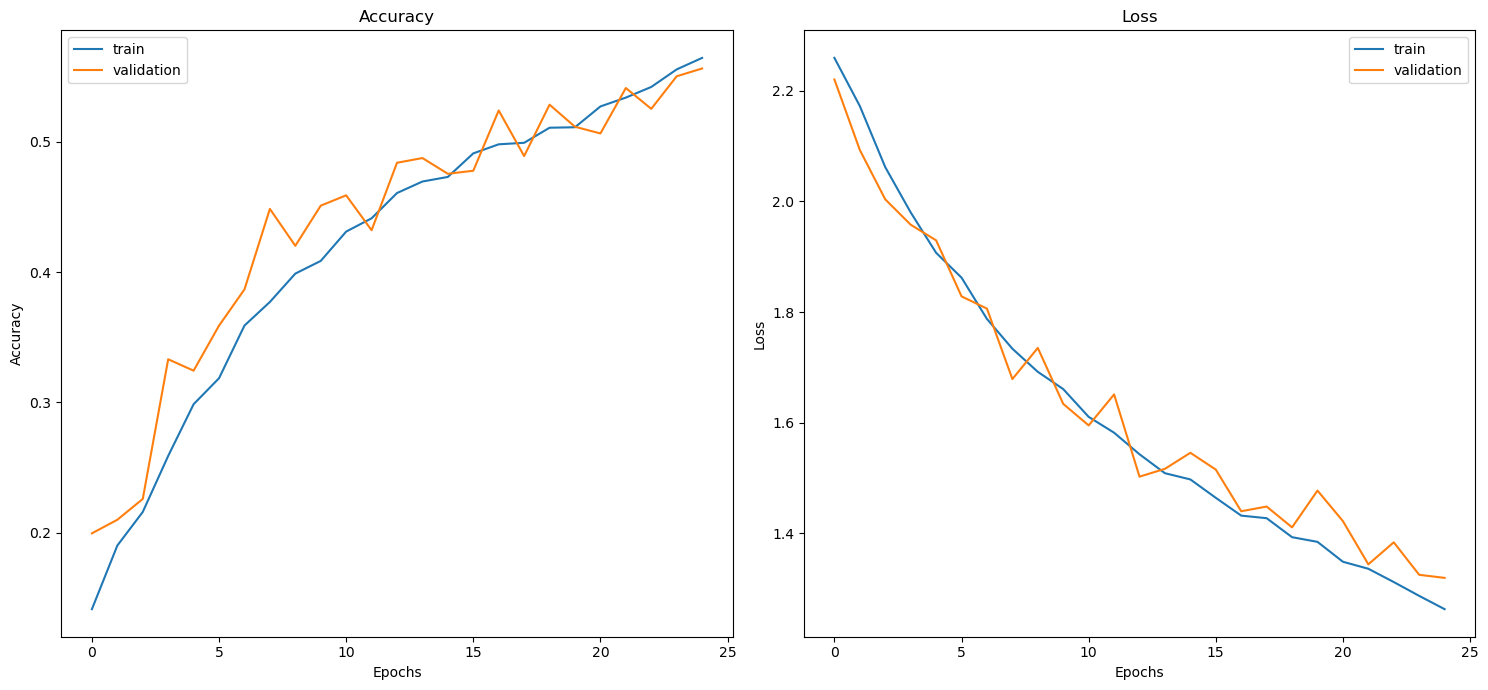

In [25]:
plt.figure(figsize=(15,7))

plt.subplot(1,2,1)
plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [27]:
model.save('/kaggle/working//custom_cnn_1d_2.1M_reg_aug.h5')

In [28]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

225/225 [==============================] - 8s 36ms/step


In [ ]:
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)
plt.savefig('/kaggle/working/2.1M_conf_matrix.png', dpi = 1000)

Normalized confusion matrix


# Majority Vote

In [1]:
def majority_vote(scores):
    values, counts = np.unique(scores,return_counts=True)
    ind = np.argmax(counts)
    return values[ind]

In [ ]:
preds = model.predict(X_test, batch_size=64, verbose=0)

In [ ]:
scores_songs = np.split(np.argmax(preds, axis=1), 300)
label_songs = np.split(np.argmax(y_test, axis=1), 300)
scores_songs = [majority_vote(scores) for scores in scores_songs]
label = [majority_vote(scores) for scores in label_songs]

In [ ]:
from sklearn.metrics import accuracy_score
print("majority voting system (acc) = {:.3f}".format(accuracy_score(label, scores_songs)))